In [1]:
import algos
import bandit
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import utils

plt.rcParams['figure.figsize'] = [7, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

DS_NAME = None #None for synthesize, or {"LastFM"}
N_SWITCHES = 150
N_BANDITS = 5
OPT_SIZE = 2
HORIZON = 250
max_n_expert = len(list(combinations(np.arange(N_BANDITS),OPT_SIZE)))
N_EXPERT = None #None: All possible combinations
if N_EXPERT is not None:
    print(f'N_EXPERT = {N_EXPERT}')
    assert N_EXPERT<=max_n_expert, f"The number of expert ({N_EXPERT}) must be smaller than the maximum combination ({max_n_expert})"
assert N_BANDITS<=HORIZON, f"The number of arm ({N_BANDITS}) must be smaller than the horizon ({HORIZON})"
N_EXPS = 2 #Repeat experiments
GAP_THRESHOLD = min(1,np.sqrt(N_BANDITS*np.log(N_SWITCHES+1)/HORIZON))
kwargs = {'switches_cache_step': 10,
          'gap_constrain':GAP_THRESHOLD*1.05}
assert kwargs['gap_constrain']>=GAP_THRESHOLD, f"kwargs['gap_constrain'] ({kwargs['gap_constrain']}) must be larger than GAP_THRESHOLD ({GAP_THRESHOLD})"

#EWAmaxStats params
N_UNBIASED_OBS = 1

## Regret vs Number of switches

  0%|          | 0/2 [00:00<?, ?it/s]

Optimal expert index = 2
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1
2 arms left after elimination: [ 4.42857143e-01 -1.00000000e+03 -1.00000000e+03 -1.00000000e+03
  4.28571429e-02].


 50%|█████     | 1/2 [00:23<00:23, 23.70s/it]

MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1


100%|██████████| 2/2 [00:47<00:00, 23.69s/it]


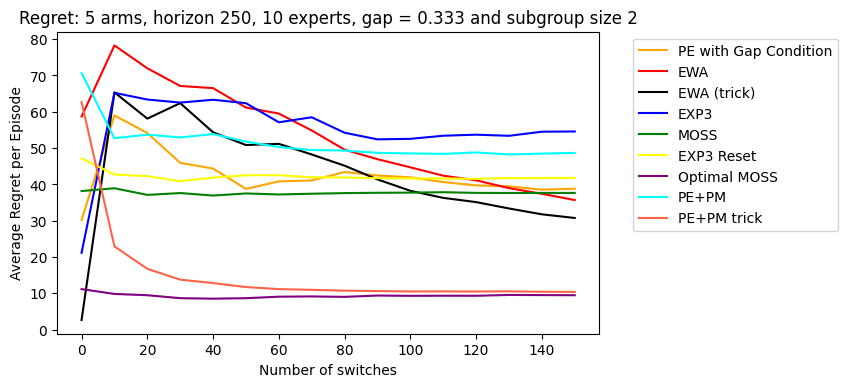

In [2]:
(X, regret_dict, title, xlabel, ylabel) = utils.switches_exp(N_EXPS, N_SWITCHES, N_BANDITS, HORIZON, 
                   N_UNBIASED_OBS, OPT_SIZE, N_EXPERT, DS_NAME, **kwargs)
indices = np.arange(0, X.shape[0], kwargs['switches_cache_step']).astype(int)
X = X[indices]
meta_regrets = regret_dict['meta_regrets']
exp3_regrets = regret_dict['exp3_regrets']
moss_regrets = regret_dict['moss_regrets']
exp3_reset_regrets = regret_dict['exp3_reset_regrets']
meta_trick_regrets = regret_dict['meta_trick_regrets']
MetaPElargeGap_regrets = regret_dict['MetaPElargeGap_regrets']
opt_moss_regrets = regret_dict['opt_moss_regrets']
MetaPM_regrets = regret_dict['MetaPM_regrets']
MetaPMtrick_regrets = regret_dict['MetaPMtrick_regrets']

# if N_EXPERT is None:
#     N_EXPERT = env.n_experts
# X = np.arange(N_SWITCHES+1)
# env = bandit.MetaBernoulli(n_bandits=N_BANDITS, opt_size=OPT_SIZE, n_tasks=N_SWITCHES+1, 
#                        n_experts=N_EXPERT, ds_name=DS_NAME, **kwargs)
# meta_regrets = np.load('meta_regrets.npy')
# meta_trick_regrets = np.load('meta_trick_regrets.npy')
# exp3_regrets = np.load('exp3_regrets.npy')
# moss_regrets = np.load('moss_regrets.npy')
# exp3_reset_regrets = np.load('exp3_reset_regrets.npy')
# title = f'Regret: {N_BANDITS} arms, horizon {HORIZON}, {N_EXPERT} experts and subgroup size {OPT_SIZE}'
# xlabel, ylabel = 'Number of switches', 'Average Regret per Episode'
# step = kwargs['switches_cache_step']
# indices = np.arange(0, X.shape[0], step).astype(int)
# utils.plot(X[indices], meta_regrets[:,indices], exp3_regrets[:,indices], moss_regrets[:,indices], exp3_reset_regrets[:,indices], meta_trick_regrets[:,indices], title, xlabel, ylabel)

In [3]:
# meta_Y = np.mean(meta_regrets, axis=0)
# meta_dY = 2*np.sqrt(np.var(meta_regrets, axis=0))
# MetaPElargeGap_Y = np.mean(MetaPElargeGap_regrets, axis=0)
# MetaPElargeGap_dY = 2*np.sqrt(np.var(MetaPElargeGap_regrets, axis=0))
# meta_trick_Y = np.mean(meta_trick_regrets, axis=0)
# meta_trick_dY = 2*np.sqrt(np.var(meta_trick_regrets, axis=0))
# exp3_Y = np.mean(exp3_regrets, axis=0)
# exp3_dY = 2*np.sqrt(np.var(exp3_regrets, axis=0))
# exp3_reset_Y = np.mean(exp3_reset_regrets, axis=0)
# exp3_reset_dY = 2*np.sqrt(np.var(exp3_reset_regrets, axis=0))
# moss_Y = np.mean(moss_regrets, axis=0)
# moss_dY = 2*np.sqrt(np.var(moss_regrets, axis=0))
# opt_moss_Y = np.mean(opt_moss_regrets, axis=0)
# opt_moss_dY = 2*np.sqrt(np.var(opt_moss_regrets, axis=0))
# MetaPM_Y = np.mean(MetaPM_regrets, axis=0)
# MetaPM_dY = 2*np.sqrt(np.var(MetaPM_regrets, axis=0))
# MetaPMtrick_Y = np.mean(MetaPMtrick_regrets, axis=0)
# MetaPMtrick_dY = 2*np.sqrt(np.var(MetaPMtrick_regrets, axis=0))
# plt.plot(X, MetaPElargeGap_Y, '-', color='orange', label = "PE with Gap Condition")
# plt.fill_between(X, MetaPElargeGap_Y - MetaPElargeGap_dY, MetaPElargeGap_Y + MetaPElargeGap_dY, color='orange', alpha=0.2)
# plt.plot(X, meta_Y, '-', color='red', label = "EWA")
# plt.fill_between(X, meta_Y - meta_dY, meta_Y + meta_dY, color='red', alpha=0.2)
# plt.plot(X, meta_trick_Y, '-', color='black', label = "EWA (trick)")
# plt.fill_between(X, meta_trick_Y - meta_trick_dY, meta_trick_Y + meta_trick_dY, color='black', alpha=0.2)
# plt.plot(X, exp3_Y, '-', color='blue', label = "EXP3")
# plt.fill_between(X, exp3_Y - exp3_dY, exp3_Y + exp3_dY, color='blue', alpha=0.2)
# plt.plot(X, moss_Y, '-', color='green', label = "MOSS")
# plt.fill_between(X, moss_Y - moss_dY, moss_Y + moss_dY, color='green', alpha=0.2)
# plt.plot(X, exp3_reset_Y, '-', color='yellow', label = "EXP3 Reset")
# plt.fill_between(X, exp3_reset_Y - exp3_reset_dY, exp3_reset_Y + exp3_reset_dY, color='yellow', alpha=0.2)
# plt.plot(X, opt_moss_Y, '-', color='purple', label = "Optimal MOSS")
# plt.fill_between(X, opt_moss_Y - opt_moss_dY, opt_moss_Y + opt_moss_dY, color='pink', alpha=0.2)
# plt.plot(X, MetaPM_Y, '-', color='cyan', label = "PE+PM")
# plt.fill_between(X, MetaPM_Y - MetaPM_dY, MetaPM_Y + MetaPM_dY, color='cyan', alpha=0.2)
# plt.plot(X, MetaPMtrick_Y, '-', color='tomato', label = "PE+PM trick")
# plt.fill_between(X, MetaPMtrick_Y - MetaPMtrick_dY, MetaPMtrick_Y + MetaPMtrick_dY, color='tomato', alpha=0.2)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.ylim([0, 80])
# # plt.yscale('log')
# # plt.legend()
# plt.legend(bbox_to_anchor=(1.05, 1))
# plt.title(title)
# pass

## Regret vs Horizon

  0%|          | 0/2 [00:00<?, ?it/s]

Optimal expert index = 3
MetaPM: self.delta_n = 0.5029355922281563, self.learning_rate=1
MetaPM: self.delta_n = 0.5029355922281563, self.learning_rate=1
5 arms left after elimination: [0.47058824 0.05882353 0.11764706 0.         0.        ].
MetaPM: self.delta_n = 0.6336591393895985, self.learning_rate=1
MetaPM: self.delta_n = 0.6336591393895985, self.learning_rate=1
2 arms left after elimination: [ 7.27272727e-02 -1.00000000e+03 -1.00000000e+03 -1.00000000e+03
  0.00000000e+00].
MetaPM: self.delta_n = 0.7253586417833604, self.learning_rate=1
MetaPM: self.delta_n = 0.7253586417833604, self.learning_rate=1
4 arms left after elimination: [ 4.67741935e-01 -1.00000000e+03  0.00000000e+00  0.00000000e+00
  0.00000000e+00].
MetaPM: self.delta_n = 0.7983604881752248, self.learning_rate=1
MetaPM: self.delta_n = 0.7983604881752248, self.learning_rate=1
2 arms left after elimination: [ 3.78787879e-01 -1.00000000e+03 -1.00000000e+03 -1.00000000e+03
  3.18181818e-01].
MetaPM: self.delta_n = 0.8600

 50%|█████     | 1/2 [02:03<02:03, 123.73s/it]

MetaPM: self.delta_n = 0.5029355922281563, self.learning_rate=1
MetaPM: self.delta_n = 0.5029355922281563, self.learning_rate=1
5 arms left after elimination: [0.29411765 0.         0.         0.         0.        ].
MetaPM: self.delta_n = 0.6336591393895985, self.learning_rate=1
MetaPM: self.delta_n = 0.6336591393895985, self.learning_rate=1
MetaPM: self.delta_n = 0.7253586417833604, self.learning_rate=1
MetaPM: self.delta_n = 0.7253586417833604, self.learning_rate=1
3 arms left after elimination: [ 5.80645161e-01  0.00000000e+00  0.00000000e+00 -1.00000000e+03
 -1.00000000e+03].
MetaPM: self.delta_n = 0.7983604881752248, self.learning_rate=1
MetaPM: self.delta_n = 0.7983604881752248, self.learning_rate=1
3 arms left after elimination: [ 5.75757576e-01 -1.00000000e+03 -1.00000000e+03  3.03030303e-02
  0.00000000e+00].
MetaPM: self.delta_n = 0.8600077654377468, self.learning_rate=1
MetaPM: self.delta_n = 0.8600077654377468, self.learning_rate=1
3 arms left after elimination: [ 4.285714

100%|██████████| 2/2 [04:08<00:00, 124.01s/it]


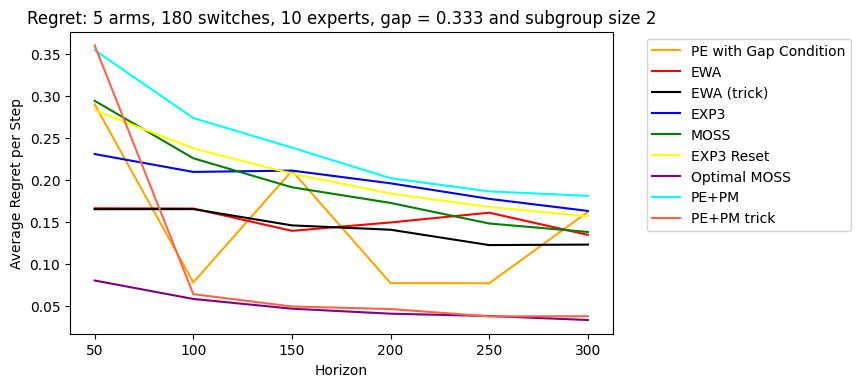

In [4]:
horizon_list = np.arange(50, 310, 50)
n_switches = np.ceil(N_SWITCHES*max(horizon_list)/HORIZON).astype(int)
# horizon_list = np.array([1, 100, 300])
(X_h, regret_dict_h, title, xlabel, ylabel) = \
utils.horizon_exp(N_EXPS, n_switches, N_BANDITS, N_UNBIASED_OBS, OPT_SIZE, N_EXPERT, 
                  DS_NAME, horizon_list = horizon_list, **kwargs)
pass

# N_EXPS = 100
# N_SWITCHES = 3000
# env = bandit.MetaBernoulli(n_bandits=N_BANDITS, opt_size=OPT_SIZE, n_tasks=N_SWITCHES+1, 
#                        n_experts=N_EXPERT, ds_name=DS_NAME, **kwargs)
# X = np.array([1, 100, 300])
# meta_regrets = np.load('meta_regrets_h.npy')
# exp3_regrets = np.load('exp3_regrets_h.npy')
# moss_regrets = np.load('moss_regrets_h.npy')
# exp3_reset_regrets = np.load('exp3_reset_regrets_h.npy')
# if N_EXPERT is None:
#     N_EXPERT = env.n_experts
# title = f'Regret: {N_EXPS} experiments, {N_BANDITS} arms, {N_SWITCHES} switches, {N_EXPERT} experts and subgroup size {OPT_SIZE}'
# xlabel, ylabel = 'Horizon', 'Average Regret per Step'
# utils.plot(X, meta_regrets, exp3_regrets, moss_regrets, exp3_reset_regrets, meta_regrets, title, xlabel, ylabel)

## Regret vs # of arm

  0%|          | 0/5 [00:00<?, ?it/s]

Optimal expert index = 2
MetaPM: self.delta_n = 0.8463735570799408, self.learning_rate=1
MetaPM: self.delta_n = 0.8463735570799408, self.learning_rate=1



 20%|██        | 1/5 [00:25<01:40, 25.22s/it]

Optimal expert index = 1
MetaPM: self.delta_n = 0.9051646666235111, self.learning_rate=1
MetaPM: self.delta_n = 0.9051646666235111, self.learning_rate=1



 40%|████      | 2/5 [00:50<01:15, 25.23s/it]

Optimal expert index = 7
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1
2 arms left after elimination: [-1.00000000e+03 -1.00000000e+03  5.28571429e-01 -1.00000000e+03
  3.57142857e-01].



 60%|██████    | 3/5 [01:15<00:50, 25.24s/it]

Optimal expert index = 8
MetaPM: self.delta_n = 0.9074502834601537, self.learning_rate=1
MetaPM: self.delta_n = 0.9074502834601537, self.learning_rate=1



 80%|████████  | 4/5 [01:40<00:25, 25.19s/it]

Optimal expert index = 3
MetaPM: self.delta_n = 0.8963165183064496, self.learning_rate=1
MetaPM: self.delta_n = 0.8963165183064496, self.learning_rate=1



  0%|          | 0/5 [00:00<?, ?it/s]

Optimal expert index = 0
MetaPM: self.delta_n = 0.8463735570799408, self.learning_rate=1
MetaPM: self.delta_n = 0.8463735570799408, self.learning_rate=1



 20%|██        | 1/5 [00:25<01:42, 25.73s/it]

Optimal expert index = 5
MetaPM: self.delta_n = 0.9051646666235111, self.learning_rate=1
MetaPM: self.delta_n = 0.9051646666235111, self.learning_rate=1



 40%|████      | 2/5 [00:51<01:16, 25.55s/it]

Optimal expert index = 2
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1



 60%|██████    | 3/5 [01:16<00:50, 25.31s/it]

Optimal expert index = 5
MetaPM: self.delta_n = 0.9074502834601537, self.learning_rate=1
MetaPM: self.delta_n = 0.9074502834601537, self.learning_rate=1
6 arms left after elimination: [0.1369863  0.02739726 0.         0.         0.         0.        ].



 80%|████████  | 4/5 [01:40<00:25, 25.09s/it]

Optimal expert index = 10
MetaPM: self.delta_n = 0.8963165183064496, self.learning_rate=1
MetaPM: self.delta_n = 0.8963165183064496, self.learning_rate=1



100%|██████████| 2/2 [04:12<00:00, 126.21s/it]


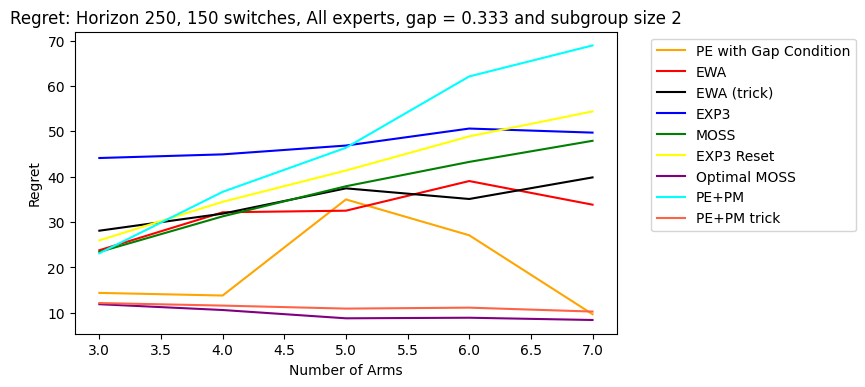

In [5]:
n_bandits_list = np.arange(3,8,1)
# n_switches = np.ceil(10*N_SWITCHES*max(n_bandits_list)/N_BANDITS).astype(int)
(X_b, regret_dict_b, title, xlabel, ylabel) = \
utils.arm_exp(N_EXPS, N_SWITCHES, HORIZON, N_UNBIASED_OBS, 
              OPT_SIZE, N_EXPERT, DS_NAME, n_bandits_list, **kwargs)
pass

## Regret vs subgroup size

  0%|          | 0/5 [00:00<?, ?it/s]

Optimal expert index = 4
MetaPM: self.delta_n = 0.8107539903387555, self.learning_rate=1
MetaPM: self.delta_n = 0.8107539903387555, self.learning_rate=1



 20%|██        | 1/5 [00:24<01:36, 24.11s/it]

Optimal expert index = 1
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1



 40%|████      | 2/5 [00:48<01:12, 24.08s/it]

Optimal expert index = 1
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1



 60%|██████    | 3/5 [01:12<00:48, 24.10s/it]

Optimal expert index = 3
MetaPM: self.delta_n = 0.8107539903387555, self.learning_rate=1
MetaPM: self.delta_n = 0.8107539903387555, self.learning_rate=1
2 arms left after elimination: [-1.00000000e+03  2.14285714e-01  5.28571429e-01 -1.00000000e+03
 -1.00000000e+03].
2 arms left after elimination: [ 3.14285714e-01 -1.00000000e+03 -1.00000000e+03 -1.00000000e+03
  5.85714286e-01].



 80%|████████  | 4/5 [01:36<00:23, 24.00s/it]

Optimal expert index = 0
MetaPM: self.delta_n = 0.0, self.learning_rate=1
MetaPM: self.delta_n = 0.0, self.learning_rate=1
2 arms left after elimination: [ 4.85714286e-01 -1.00000000e+03 -1.00000000e+03  7.85714286e-01
 -1.00000000e+03].
2 arms left after elimination: [-1.00000000e+03 -1.00000000e+03  8.14285714e-01  3.14285714e-01
 -1.00000000e+03].



  0%|          | 0/5 [00:00<?, ?it/s]

Optimal expert index = 2
MetaPM: self.delta_n = 0.8107539903387555, self.learning_rate=1
MetaPM: self.delta_n = 0.8107539903387555, self.learning_rate=1
3 arms left after elimination: [-1.00000000e+03  2.57142857e-01  7.28571429e-01 -1.00000000e+03
  0.00000000e+00].



 20%|██        | 1/5 [00:23<01:35, 23.99s/it]

Optimal expert index = 7
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1
2 arms left after elimination: [-1.00000000e+03  1.71428571e-01  5.14285714e-01 -1.00000000e+03
 -1.00000000e+03].



 40%|████      | 2/5 [00:47<01:11, 23.74s/it]

Optimal expert index = 1
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1
MetaPM: self.delta_n = 0.913558259818836, self.learning_rate=1



 60%|██████    | 3/5 [01:11<00:47, 23.61s/it]

Optimal expert index = 0
MetaPM: self.delta_n = 0.8107539903387555, self.learning_rate=1
MetaPM: self.delta_n = 0.8107539903387555, self.learning_rate=1



 80%|████████  | 4/5 [01:34<00:23, 23.56s/it]

Optimal expert index = 0
MetaPM: self.delta_n = 0.0, self.learning_rate=1
MetaPM: self.delta_n = 0.0, self.learning_rate=1
2 arms left after elimination: [ 2.42857143e-01 -1.00000000e+03 -1.00000000e+03  4.85714286e-01
 -1.00000000e+03].



100%|██████████| 2/2 [03:57<00:00, 118.98s/it]


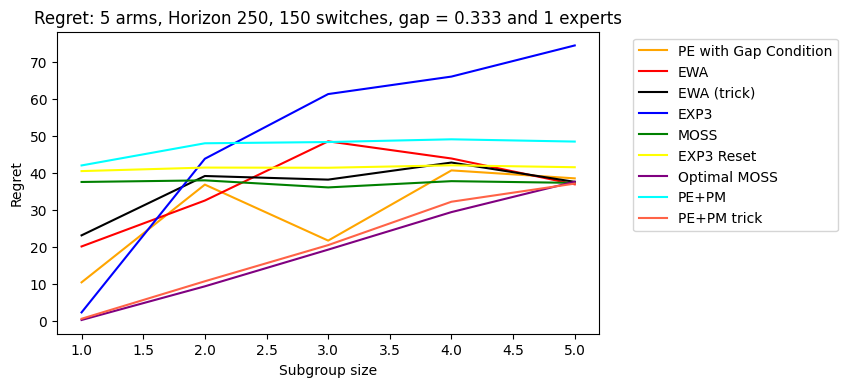

In [6]:
(X_e, regret_dict_e, title, xlabel, ylabel) = utils.subgroup_size_exp(N_EXPS, 
                                  N_SWITCHES, N_BANDITS, HORIZON, N_UNBIASED_OBS, N_EXPERT, DS_NAME, 
                                  opt_size_list = np.arange(1,N_BANDITS+1,1), **kwargs)
pass